# The Beginnings of a Larval Transport Model 

## Maia Heffernan

### Western Washington University

### Winter Quarter 2023, Final Project for Earth an Ocean Data Analysis



For the past year I have been doing research with Dr. Shawn Arellano. For my project we have been studying the Warén's larva, a newly-found larval form of the snail species *Ifremeria nautilei.* They are endemic to the Lau Back-Arc Basin in the Southwest Pacific Ocean. 

Currently in this research, we are trying to create a larval transport model to determine where larvae are transported when released into the plankton. 

To do this, we are hoping to correlate the swimming speed of a specific larval species along with its life span and respiration rate to a larger physical processes dataset that models the water movement at our sampling sites.

This will be a large, ongoing process that will hopefully include the use of the Regional Ocean Modeling System (ROMS). However, for this final project I have started this longer process by creating a map of our sampling locations, and doing inital survival analysis of the larvae with a Kaplan Meier Analysis.

## First I will start by importing all the packages that are used in this project:

In [78]:
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 as nc 
from lifelines import KaplanMeierFitter
import urllib.request as urllib
import scipy.interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as patches
import rasterio

## One important aspect of creating a larval transport model is being able to understand the biological data we collected. 

### Below is the code that shows a Kaplan-Meier survival analysis for the Warén's larvae we cultured in the lab:

In [79]:
culture_survival = pd.read_csv('/Users/maiaheffernan/Desktop/My_Lau_Resources/Warens_Stuff/CultureSurvival_forAnalysisWarens.csv')

In [80]:
culture_survival.head(5)

,Dive,Collection,Individual,Temperature,InitialStage,Days,Mortality
0,J2-1407,BXC_D,52,4to14,W,3,0
1,J2-1407,BXC_D,53,4to14,W,6,1
2,J2-1404,BXC,44,4to14,W,10,0
3,J2-1404,BXC,23,4,W,4,0
4,J2-1404,BXC,63,4to14,W,10,1


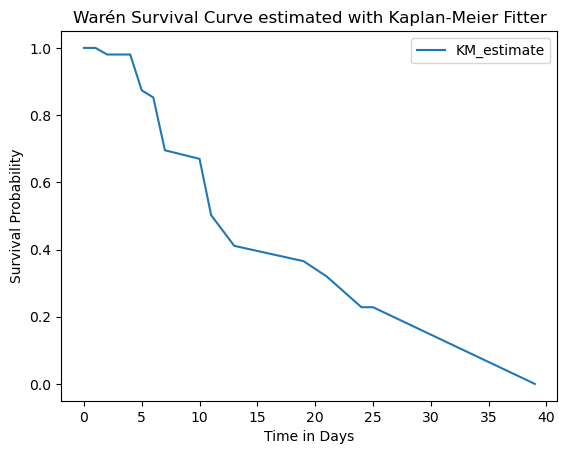

In [81]:
culture_survival_data= pd.DataFrame(culture_survival)
culture_survival_data.astype({'Days': 'datetime64[ns]'}).dtypes
culture_survival_data.set_index('Days')
kmf = KaplanMeierFitter()
culture_survival_data["Days"]=culture_survival_data.Days
culture_survival_data["Mortality"]=culture_survival_data.Mortality
culture_survival_data["Days"].astype("string")
culture_survival_data["Mortality"].astype("string")

kmf.fit(durations=culture_survival_data.Days, event_observed=culture_survival_data.Mortality)
# Plot the survival function
ax=kmf.survival_function_.plot()
plt.title('Warén Survival Curve estimated with Kaplan-Meier Fitter')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### The above graph shows that as time goes on, larval survival probability decreases. They can only live for so long on the energy stores that they are born with.

### Below is some more information about the dataset that I used to make this figure.

In [82]:
culture_survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Dive          52 non-null     object
 1   Collection    52 non-null     object
 2   Individual    52 non-null     object
 3   Temperature   52 non-null     object
 4   InitialStage  52 non-null     object
 5   Days          52 non-null     int64 
 6   Mortality     52 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 3.0+ KB


In [83]:
culture_survival.shape

(52, 7)

## Below is larval respiration data that I will not do anything with for this project, but am loading in for future use:

In [84]:
meanRespiration = pd.read_csv('/Users/maiaheffernan/Downloads/meanResp.csv')

In [85]:
meanRespiration.head()

,1,28.88177275,1.39788E-08
0,1,27.237569,1.318300e-08
1,1,47.572466,2.302510e-08
2,1,3.608946,1.746730e-09
3,1,5.097050,2.466970e-09
4,2,12.368841,5.986520e-09


## One of my main goals for this project is to being creating code to work with large netCDF files. Below is some code that reads in a netCDF dataset and manipulates it so it is easier to works with individual columns and aspects. A big thank you to Paige for helping me figure this out!

> #### I do not use this initial read-in code in this project, but I am including it because I am sure it will come in handy in the future when I have various ROMS datasets that I want to work with.

> #### The data comes from NOAA's Environmental Research Division Data Access Program (ERDDA) database. To acquire the data, it asks you specify longitude and latitude ranges, and provides topographical information for that area. More information can be found here: [NOAA ERDDAP](https://www.ncei.noaa.gov/products/weather-climate-models/using-erddap)

In [86]:
from netCDF4 import Dataset
import numpy as np
import numpy.ma as ma
file = '/Volumes/EODA/final_project/lau_netcdf_data.nc' # mention the path to the downloaded file
my_data = Dataset(file, mode='r') # read the data 
print(type(my_data)) # print the type of the data 
print(my_data.variables.keys()) # print the variables in the data

#Then create variables for each column to manipulate 
lats = my_data.variables['latitude'][:]  
longs = my_data.variables['longitude'][:]
topo = my_data.variables['topo'][:]

<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['latitude', 'longitude', 'topo'])


## I am most excited about the following part of my project. It includes a large-scale map of the region in the Lau Back-Arc Basin where we conducted our studies. The larger map is followed by a zoomed-in map to see the precise sampling locations.

In [87]:
import urllib.request as urllib
from io import StringIO
import csv
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pickle as pickle
import matplotlib.patches as patches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


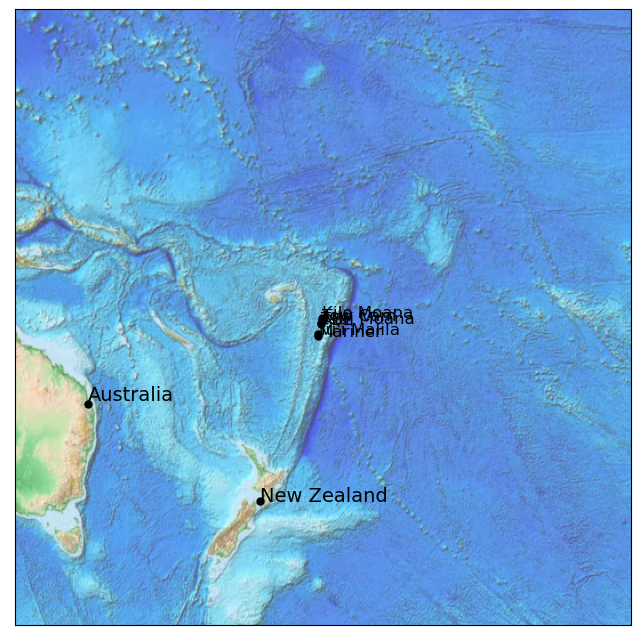

In [88]:
ax = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=-20, lat_1=-23,lat_2=-19,lon_0= -176,lon_1=-177, lon_2=-175,)
m.etopo(scale=0.5, alpha=0.7)

# Map (lon, lat) to (x, y) for plotting

#Nearby countries

o,p = m(153.0260, -27.4705)
plt.plot(o, p, 'ok', markersize=5)
plt.text(o, p, 'Australia', horizontalalignment = 'left', verticalalignment = 'bottom', fontsize=14);

q,r = m(174.8860, -40.9006)
plt.plot(q, r, 'ok', markersize=5)
plt.text(q, r, 'New Zealand', fontsize=14);


#below are the (lon, lat) for sampling locations. 
#Though they are squished, they are included here to create context for the next figure.

x, y = m(-176.13336, -20.053085)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Kilo Moana', fontsize=12);

a,b = m(-176.13761,-20.318079)
plt.plot(a, b, 'ok', markersize=5)
plt.text(a, b, 'Tow Cam', fontsize=12);

c,d= a,b = m(-176.18337,-20.682322)
plt.plot(c, d, 'ok', markersize=5)
plt.text(c, d, 'Tahi Moana', fontsize=12);

e,f= m(-176.1908,-20.761164)
plt.plot(e, f, 'ok', markersize=5)
plt.text(e, f, 'ABE', fontsize=12);

g,h= m(-176.56816,-21.989084)
plt.plot(g, h, 'ok', markersize=5)
plt.text(g, h, 'Tu\'i Malila', fontsize=12);

i,j= m(-176.60161,-22.180467)
plt.plot(i, j, 'ok', markersize=5)
plt.text(i, j, 'Mariner', fontsize=12);

plt.show()

### Though the sampling locations are squished together in the above figure, I wanted to include them so that there is a refernce point for the following figure. 

In [89]:
import rasterio
import matplotlib.pyplot as plt

#loading in the previously mentioned NOAA netCDF data and reading it as raster data
file = rasterio.open('lau_netcdf_data.nc')
dataset = file.read()
print(dataset.shape)

(1, 481, 361)


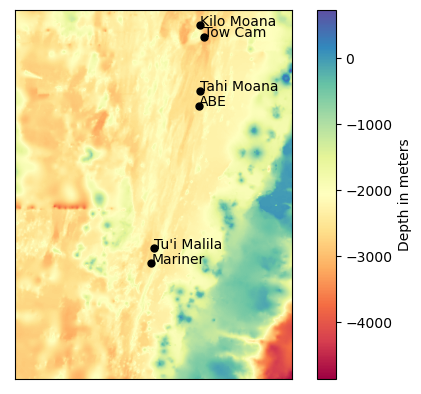

In [90]:
#plotting the raster data!

c=plt.imshow(dataset[0], cmap='Spectral')
plt.colorbar(c, label="Depth in meters")

#Placing site labels
#The numbers are not lat and lon coordinates, but instead reference the graph's axis tick marks, which have been removed.
#Since matplotlib does not use lat and lon coordinates, I referenced a map of the sites from a previous expedition and matched the relative locations on my graph.

plt.plot(240, 20, 'ok', markersize=5)
plt.text(240, 20, 'Kilo Moana', fontsize=10);


plt.plot(245,35, 'ok', markersize=5)
plt.text(245,35, 'Tow Cam', fontsize=10);


plt.plot(240,105, 'ok', markersize=5)
plt.text(240,105, 'Tahi Moana', fontsize=10);


plt.plot(239,125, 'ok', markersize=5)
plt.text(239,125, 'ABE', fontsize=10);


plt.plot(180,310, 'ok', markersize=5)
plt.text(180,310, 'Tu\'i Malila', fontsize=10);


plt.plot(177,330, 'ok', markersize=5)
plt.text(177,330, 'Mariner', fontsize=10);

ax = plt.gca()

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### The above graph shows an up-close look at the sampling sights. I am sure there is a way to do with some kind of topographic map plotter, however I was not able to find code for this. Instead, I thought it might be beneficial to see the depth profile of the sampling locations. The blue areas to the right are the country of Tonga and some surrounding land masses. There is a large dropoff into a trench which is shown in the very bottom right-hand corner.

## This project is only just a start to what I am sure will become a much more complicated model, but I am so glad that I got to work on it for my final to get the ball rolling. Thank you so much Emily and Paige, it has been an awesome quarter!